In [52]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Initial data reading
#### Read the folder files with the mean of $e_{normal}$ and $e_{tumor}$
1. Store names in a list
2. Store values in a list of list to transform later into an array

In [53]:
folder_path = "./data_generated/mean_exp_values/"
file_list = []
data_store = []

for file in os.listdir(folder_path):
    # store the file name withouth path and extention
    file_list.append(file.split('.')[0])
    # store the data from each file
    data_store.append(pd.read_csv(folder_path+'/'+file,
                                  sep='\t',header=None).iloc[:,0])
# numpy array
data_store = np.array(data_store)

### Preparing data

Separating tumor and normal mean values by using numpy mask to evaluate in array and listing tissues and genes

In [54]:
# Creating masks
normal_mask = [name[:6] == 'normal' for name in file_list]
tumor_mask = [name[:5] == 'tumor' for name in file_list]

# List of different tissues
tissues = np.unique(
    [''.join(re.findall('[A-Z]', string)) for string in file_list]
    )
# Ensemble IDs
ensbl = pd.read_csv("data_generated/ensemble.txt",sep='\t',header=None).iloc[:,0]

Precalculus matrix of differential expression:
$$ Log2 FC = Log2 (e/e_{ref})$$
df $->$ DataFrame with features as columns: ensemble IDs and samples as index: tissues

In [55]:
# Calculate log2 fold-change of gene exprssion with normal tissue as reference
Log2FC = np.log2(data_store[tumor_mask]/data_store[normal_mask])

# DataFrame of gene expression fold-change
df = pd.DataFrame(data=Log2FC,columns=ensbl,index=tissues)

### Pathways
#### Top 28 pathways from Reactome
Read the pathway data and store pathway names and genes in pathways

In [56]:
# Read the Top 28 pathways excel list
top_pathways = pd.read_excel("./data_external/data_pathways/pathways2_sorted.xls",header=None)
# Name the columns
top_pathways.columns = ["Ensemble","Pathways"]

# Count pathways
pathways_names = pd.unique(top_pathways.Pathways)
# Count genes in pathways
genes_annotated = pd.unique(top_pathways.Ensemble)

# Print ranges
print(" Top Pathways:",
      pathways_names.shape[0],"\n",
      "Annotated Genes:",
      genes_annotated.shape[0]
      )

 Top Pathways: 28 
 Annotated Genes: 10785


Get matching genes in pathways and evaluate in top-pathways dataframe

In [57]:
# Genes in pathways
genes_path = set(ensbl) & set(genes_annotated)

# Pathways with annotated genes
pathways_annotated = top_pathways.query('Ensemble in @genes_path')

### Generate X Matrix to transform

In [58]:
X = []
for pathway in pathways_names:
    # genes evaluated in pathway (variable to operate)
    g_pathways = df[
        pathways_annotated[pathways_annotated.Pathways == pathway].Ensemble
    ]
    # Ecuation above
    X.append(np.sum(abs(g_pathways),axis=1)/g_pathways.shape[1])

X = pd.DataFrame(data=X, columns=tissues,index=pathways_names)

# Store the average pathway data
X.to_csv("./figures_tables/tableIII.csv")
X.shape

(28, 15)

### Average logarithmic fold-change of genes in top pathways in BRCA

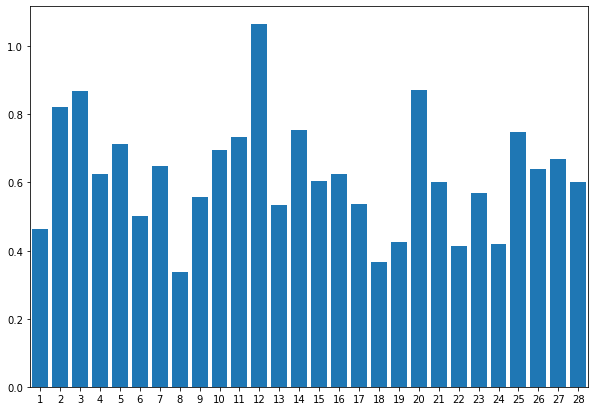

In [59]:
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,29),X.BRCA)
plt.xticks(np.arange(1,29))
plt.xlim(0.5,28.5)
plt.show()

### Principal Components Analysis
- Transpose the matrix X first
- And make an uncentered PCA

In [65]:
Y = X.T
# PCA class
pca = PCA(6)
# Tissues as samples and pathways as features
P_matrix = pca.fit(Y)
# Make the mean 0 to uncenter
pca.mean_ = np.zeros(Y.shape)
# PCA transformation matrix
P_matrix = pca.transform(Y)

print(P_matrix.shape)

(15, 6)


### Components
Histogram of components

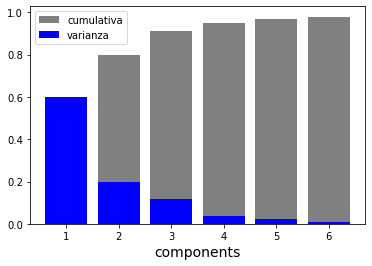

In [64]:
variance = pca.explained_variance_ratio_
label = [r'cumulativa',r'varianza']

plt.bar(np.arange(1,7), variance.cumsum(), color='grey')
plt.bar(np.arange(1,7), variance, color='blue')
plt.xlabel('components', size=14)

plt.legend(label)

Table of components

In [ ]:
proyections_table = pd.DataFrame(P_matrix, columns=[f'PC{i}' for i in range(1, 7)])
# Set the index as the tissues type
proyections_table.index = tissues
# Visualization
proyections_table.head(15)

,PC1,PC2,PC3,PC4,PC5,PC6
BLCA,-3.411942,0.028758,-1.069093,0.096427,0.219675,0.170302
BRCA,-3.162593,0.249421,-1.141441,0.137515,0.079870,0.069325
COAD,-3.312517,1.243775,-0.669761,0.121262,0.154084,0.166313
ESCA,-3.900865,0.587321,-0.435974,-0.159395,-0.041864,0.005436
HNSC,-2.999088,0.245472,-1.005277,0.033404,-0.081237,0.327071
KIRC,-2.947321,1.016104,-1.229499,0.343436,-0.083474,0.024773
KIRP,-2.839228,1.064312,-1.246433,0.291792,-0.018856,0.053774
LIHC,-3.781271,0.250012,-0.292646,0.669907,0.064483,0.162717
LUAD,-3.260696,0.418493,-0.922998,0.186078,0.027538,0.082858
LUSC,-4.535661,0.565234,-1.174010,0.166588,-0.129797,0.128526


### Weights
Stored in csv files

In [ ]:
# DataFrame for all components weights
for i in range(2):
    # Create the table
    pci = pd.DataFrame({f'PC{i+1}': pca.components_[i,:], 'Pathways': pathways_names})
    # Sort descending
    pci.sort_values(f'PC{i+1}',ascending=False)
    # Store it
    pci.to_csv(f'./figures_tables/weights_PC{i+1}.csv')

Scatterplot of the first two components

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

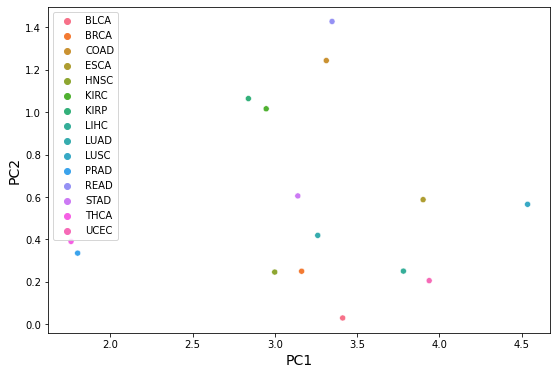

In [ ]:
plt.figure(figsize = (9,6))
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=X.columns)

Separate the group of points and create array of labels

In [122]:
# will be use as labels
hue = np.array(15*['Cluster 2'])

# Use numpy logical indexing to set elements in 'hue' based on conditions
hue[-P_matrix[:, 0] < 2.5] = 'Cluster 1'
hue[P_matrix[:, 1] > 0.8] = 'Cluster 3'

### Descriptive scatterplot

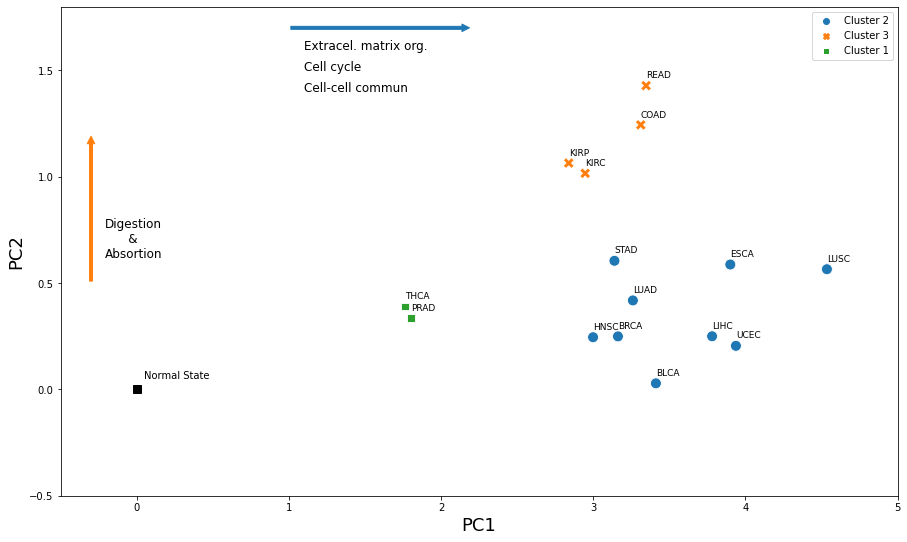

In [123]:
# Set figure dimension
fig = plt.figure(figsize = (15,9),facecolor='w')

# get current axe
ax = plt.gca()

# The axes labels
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', size=18)
# xy limits
plt.xlim(-0.5,5)
plt.ylim(-0.5,1.8)

# Scatterplot 
sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=hue, s=120, 
                 style=hue)
# Normal state point
plt.plot(0, 0, 's', color='k',markersize=8, markeredgecolor ='black')
plt.annotate('Normal State',xy=(0.05,0.05), xycoords='data',fontsize=10)

# Horizontal arrow
harrow = mpatches.FancyArrowPatch((1, 1.7), (2.2, 1.7),
                                 mutation_scale=15, color="C0")
# Horizontal arrow annotations
ax.annotate('Extracel. matrix org.',
            xy=(1.1,1.6), xycoords='data',fontsize=12)
ax.annotate('Cell cycle',
            xy=(1.1, 1.5), xycoords='data',fontsize=12)
ax.annotate('Cell-cell commun',
            xy=(1.1,1.4), xycoords='data',fontsize=12)
ax.add_patch(harrow)
# Vertical arrow
varrow = mpatches.FancyArrowPatch((-0.3, 0.5), (-0.3, 1.2),
                                 mutation_scale=15, color="C1")
# Vertical annotations
ax.annotate('Digestion',
            xy=(105, 315), xycoords='figure pixels',fontsize=12)
ax.annotate('      &',
            xy=(105, 300), xycoords='figure pixels',fontsize=12)
ax.annotate('Absortion',
            xy=(105, 285), xycoords='figure pixels',fontsize=12)
ax.add_patch(varrow)

# Add the labels to the points
for i in range(len(tissues)):
    plt.annotate(tissues[i], (-P_matrix[:,0][i], P_matrix[:,1][i]), 
                 textcoords='offset points', xytext=(0, 8),fontsize=9)

# Store the fig
fig.savefig("./figures_tables/PCA_scatterplot.pdf", bbox_inches='tight')
# Show the plot
plt.show()